# Models as layers
1 pora pretrained-model uthake layer ke tarah use kerley.

Ismai bhe layer sharing ke tarah layers ke sath us wakt ke weights bhe atay hai(use hote hai).

Calling an instance, whether it’s a layer instance or a model instance, will always reuse the existing learned representations of the instance

In [ ]:

# This means you can call a model on an input tensor and retrieve an output tensor:
y = model(x) # for eg this is a model

#If the model has multiple input tensors and multiple output tensors, it should be called with a list of tensors:
y1, y2 = model([x1, x2])

# When you call a model instance, you’re reusing the weights of the model

One simple practical example of what you can build by reusing a model instance is a vision model that uses a dual camera as its input: two parallel cameras, a few centimeters (one inch) apart. Such a model can perceive depth, which can be useful in many applications. You shouldn’t need two independent models to extract visual features from the left camera and the right camera before merging the two feeds. Such low-level processing can be shared across the two inputs: that is, done via layers that use the same weights and thus share the same representations. Here’s how you’d implement a Siamese vision model (shared convolutional base) in Keras:

In [ ]:
from keras import layers
from keras import applications
from keras import Input

# The base image-processing model is the Xception network (convolutional base only)
xception_base = applications.Xception(weights=None,include_top=False)

In [ ]:

left_input = Input(shape=(250, 250, 3))  #The inputs are 250 × 250 RGB images.
right_input = Input(shape=(250, 250, 3)) #Calls the same vision model twice

left_features = xception_base(left_input)
right_input = xception_base(right_input)

merged_features = layers.concatenate([left_features, right_input], axis=-1)
# The merged features contain information from the right visual feed and the left visual feed.

In [ ]:
#############################################################

Above are book codes now Lets try to implement them

# Mnist_Fashion
Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

The training and test data sets have 785 columns. The first column consists of the class labels and represents the article of clothing. The rest of the columns contain the pixel-values of the associated image.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print()

class_names = ["0.T-shirt/top","1.Trouser","2.Pullover","3.Dress","4.Coat","5.Sandal","6.Shirt","7.Sneaker","8.Bag","9.Ankle boot"]
display(class_names)

['0.T-shirt/top',
 '1.Trouser',
 '2.Pullover',
 '3.Dress',
 '4.Coat',
 '5.Sandal',
 '6.Shirt',
 '7.Sneaker',
 '8.Bag',
 '9.Ankle boot']

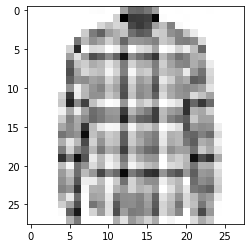

Actual Label : 6


In [2]:
# Visualizing Data¶
pic  = x_test[7]
plt.imshow(pic,cmap = plt.cm.binary)
plt.show()

# Actual Label
print("Actual Label :",y_test[7])

In [3]:
# Normalizing data
x_train, x_test = x_train/255.0, x_test/255.0

# One hot encoding
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train) 
y_test = to_categorical(y_test)

print(x_train.shape)
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


# We have 2 prolmes here:
1. Our pretrained require shape of (32,32) but we have (28,28)

2. Our data is Greay scale (1-chanel) but our pretrained requres (3-channel) RGB

# 1st Problem Fix (Padding)

https://stackoverflow.com/questions/61309432/padding-mnist-images-from-28-28-1-to-32-32-1

The pad_width argument to np.pad works like this: ((axis 1 pad before, axis 1 pad after), ...) so if you want to pad 1 pixel on each side you should do ((0,0), (1,1), (1,1)). (Your code is padding all axes 2 on each side.)

In [4]:
print(x_train.shape)
print(x_test.shape,"\n")

new_x_train = np.pad(x_train, ((0,0),(2,2),(2,2)), 'constant')
new_x_test = np.pad(x_test, ((0,0),(2,2),(2,2)), 'constant')

print(new_x_train.shape)
print(new_x_test.shape)

(60000, 28, 28)
(10000, 28, 28) 

(60000, 32, 32)
(10000, 32, 32)


# 2nd problem fix

 Our data is of grayscale but the pretrained model is of RGB
 so we will make it of same shape by putting same data in 3 channels
https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images

In [5]:
print(new_x_train.shape)
print(new_x_test.shape,"\n")

new_x_train = np.repeat(new_x_train[..., np.newaxis], 3, -1)
new_x_test = np.repeat(new_x_test[..., np.newaxis], 3, -1)

print(new_x_train.shape)
print(new_x_test.shape)

(60000, 32, 32)
(10000, 32, 32) 

(60000, 32, 32, 3)
(10000, 32, 32, 3)


# Importing pre-trained model

In [6]:
from tensorflow.keras import Input
input_tensor = Input(shape=(32, 32, 3))

from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet',include_top=False,
                  input_tensor = input_tensor)

conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

# Now using pretrained model as layer

In [7]:
from tensorflow.keras import layers, optimizers, Input, Model

input_tensor = Input(shape=(32, 32, 3))
x = conv_base(input_tensor)
y = layers.Flatten()(x)
z = layers.Dense(256, activation='relu')(y)
z = layers.Dense(128, activation='relu')(z)
z = layers.Dense(64, activation='relu')(z)
z = layers.Dense(32, activation='relu')(z)
output_tensor = layers.Dense(10, activation='softmax')(z)

model = Model(input_tensor, output_tensor)

#SGD #RMSprop #Adam #Adadelta #Adagrad ##Adamax ###Nadam #Ftrl
opt = optimizers.Adam(lr=1e-3)
model.compile(optimizer = opt, 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)               

#freezing the convolutional base
In Keras, you freeze a network by setting its trainable attribute to False:

In [8]:
print('This is the number of trainable weights ''before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False
print('This is the number of trainable weights ''after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 36
This is the number of trainable weights after freezing the conv base: 10


# or freezing the convolutional base with fine tunning
Unfreeze some layers in the base network.

Freezing all layers up to a specific one

In [9]:
#set_trainable = False
#for layer in conv_base.layers:
#    if layer.name == 'block5_conv1':
#        set_trainable = True
#    if set_trainable:
#        layer.trainable = True
#    else:
#        layer.trainable = False
#
#print('This is the number of trainable weights ''after Un-freezing some layers of conv base:', len(model.trainable_weights))

In [10]:
batch_size = 512
epochs = 5

history = model.fit(new_x_train, y_train,batch_size=batch_size, epochs = epochs, validation_split = 0.2)

Epoch 1/5
94/94 [==============================] - 45s 474ms/step - loss: 1.8101 - accuracy: 0.2714 - val_loss: 1.1615 - val_accuracy: 0.5270
Epoch 2/5
94/94 [==============================] - 38s 408ms/step - loss: 0.8550 - accuracy: 0.6501 - val_loss: 0.6794 - val_accuracy: 0.7337
Epoch 3/5
94/94 [==============================] - 38s 407ms/step - loss: 0.4728 - accuracy: 0.8372 - val_loss: 0.3881 - val_accuracy: 0.8622
Epoch 4/5
94/94 [==============================] - 38s 407ms/step - loss: 0.3165 - accuracy: 0.8861 - val_loss: 0.2781 - val_accuracy: 0.8987
Epoch 5/5
94/94 [==============================] - 38s 407ms/step - loss: 0.2552 - accuracy: 0.9094 - val_loss: 0.2737 - val_accuracy: 0.9037


# Done Now lets save our model and use it as a layer too

In [11]:
model.save('mnist_fasion_1.h5')

In [12]:
# loading saved model
from tensorflow.keras.models import load_model
mnist_fasion = '/content/mnist_fasion_1.h5'
mnist_fasion_model = load_model(mnist_fasion)
mnist_fasion_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)               

# Remove layers
we can remove layers from our saved model if we want too

In [13]:
new_model = Model(mnist_fasion_model.inputs, mnist_fasion_model.layers[-2].output) # removing last layer
new_model.summary()
# didn't use this at the moment (Mentioned it just for educational purpose)

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg16 (Functional)           (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)               

In [14]:
from tensorflow.keras import layers, optimizers, Input, Model

input_tensor = Input(shape=(32, 32, 3))
x = mnist_fasion_model(input_tensor)       # this is our model
y = layers.Flatten()(x)
z = layers.Dense(256, activation='relu')(y)
z = layers.Dense(128, activation='relu')(z)
z = layers.Dense(64, activation='relu')(z)
z = layers.Dense(32, activation='relu')(z)
output_tensor = layers.Dense(10, activation='softmax')(z)

model = Model(input_tensor, output_tensor)

#SGD #RMSprop #Adam #Adadelta #Adagrad ##Adamax ###Nadam #Ftrl
opt = optimizers.Adam(lr=1e-3)
model.compile(optimizer = opt, 
              loss = "categorical_crossentropy",
              metrics = ["accuracy"])

model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
functional_1 (Functional)    (None, 10)                14889578  
_________________________________________________________________
flatten_1 (Flatten)          (None, 10)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2816      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 32)               

In [15]:
batch_size = 512
epochs = 5

history = model.fit(new_x_train, y_train,batch_size=batch_size, epochs = epochs, validation_split = 0.2)

Epoch 1/5
94/94 [==============================] - 13s 141ms/step - loss: 0.8620 - accuracy: 0.8248 - val_loss: 0.2973 - val_accuracy: 0.9111
Epoch 2/5
94/94 [==============================] - 13s 137ms/step - loss: 0.2176 - accuracy: 0.9281 - val_loss: 0.2696 - val_accuracy: 0.9078
Epoch 3/5
94/94 [==============================] - 13s 138ms/step - loss: 0.2057 - accuracy: 0.9288 - val_loss: 0.2561 - val_accuracy: 0.9125
Epoch 4/5
94/94 [==============================] - 13s 137ms/step - loss: 0.2029 - accuracy: 0.9287 - val_loss: 0.2634 - val_accuracy: 0.9098
Epoch 5/5
94/94 [==============================] - 13s 137ms/step - loss: 0.2001 - accuracy: 0.9294 - val_loss: 0.2549 - val_accuracy: 0.9102
